# mCNV Analysis

In [64]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels as sms
import statsmodels.api as sm
import statsmodels.formula.api
import statsmodels.formula.api as smf
import tabix
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'mcnv_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
gene_info['ensembl_id'] = [x.split('.')[0] for x in gene_info.index]

genes = pbt.BedTool(cpy.gencode_gene_bed)

dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

In [3]:
dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'gene_variant_pairs.tsv')
gene_variant = pd.read_table(fn, index_col=0)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_encode_dnase_overlap.tsv')
encode_dnase_overlap = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_encode_tf_chip_seq_overlap.tsv')
encode_chip_overlap = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_roadmap_overlap.tsv')
roadmap_overlap = pd.read_table(fn, index_col=0)

In [5]:
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'gs_info.pickle')
gs_info = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'private_output', 'cnv_processing', 'mcnvs.tsv')
mcnvs = pd.read_table(fn, index_col=0)

In [6]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'variant_regions.bed')
variant_regions = pbt.BedTool(fn)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
eqtl_tpm = pd.read_table(fn, index_col=0)
eqtl_tpm = eqtl_tpm[(gene_info.ix[eqtl_tpm.index, 'chrom'] != 'chrX') & 
                    (gene_info.ix[eqtl_tpm.index, 'chrom'] != 'chrY') &
                    (gene_info.ix[eqtl_tpm.index, 'chrom'] != 'chrM')]

## mCNV eQTLs

I want to test for an association between mCNVs and gene expression. I'm going to start
by using unrelated individuals. There are genetically unrelated people in families (for
instance the parents in a trio are unrelated) but for now I'll just take one person from
each family.

### mCNV samples

In [7]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 'unrelateds.tsv')
mcnv_samples = pd.read_table(fn, index_col=0)

In [8]:
mcnv_samples_by_wgs = mcnv_samples.copy(deep=True)
mcnv_samples_by_wgs['rna_id'] = mcnv_samples_by_wgs.index
mcnv_samples_by_wgs.index = mcnv_samples_by_wgs.wgs_id
mcnv_samples_by_wgs = mcnv_samples_by_wgs.merge(subject_meta, left_on='subject_id', right_index=True)

### mCNV filtering

I'll filter the mCNVs based on the samples I'm using here.

In [9]:
mcnvs_f = mcnvs[mcnv_samples.wgs_id]
b = mcnvs_f.apply(lambda x: x.value_counts().max() < mcnvs_f.shape[1] - np.floor(mcnvs_f.shape[1] * 0.05), axis=1)
mcnvs_f = mcnvs_f[b]

In [10]:
t = gs_info.ix[mcnvs_f.index]
s = '\n'.join(t.chrom + '\t' + t.start.astype(str) + '\t' + t.end.astype(str) + 
              '\t' + t.name) + '\n'
mcnvs_bt = pbt.BedTool(s, from_string=True)
mcnvs_bt = mcnvs_bt.sort()

In [11]:
# Let's find out which mCNVs overlap the variant regions for the genes.
res = mcnvs_bt.intersect(variant_regions, sorted=True, wo=True)
df = res.to_dataframe()
df['gene'] = df.thickEnd.apply(lambda x: x.split('_')[0])
# I'll make a mapping from gene to mCNV.
gene_to_mcnv = pd.Series(df.name.values, index=df.gene)

In [12]:
eqtl_tpm_f = eqtl_tpm[mcnv_samples.wgs_id]
eqtl_tpm_f = cpb.general.transform_standard_normal(eqtl_tpm_f)

In [13]:
mcnvs_f.to_csv(os.path.join(private_outdir, 'filtered_mcnvs.tsv'), sep='\t')

### Regression

In [15]:
def mcnv_data(gene):
    cnvs = gene_to_mcnv[gene]
    if type(cnvs) is pd.core.series.Series:
        cnvs = list(cnvs)
    else:
        cnvs = [cnvs]
    data = mcnvs_f.ix[cnvs].T
    data['exp'] = eqtl_tpm_f.ix[gene, data.index].values
    data['sex'] = (mcnv_samples_by_wgs.ix[data.index, 'sex'] == 'M').values
    return data

def mcnv_regression(gene):
    cnvs = gene_to_mcnv[gene]
    if type(cnvs) is pd.core.series.Series:
        cnvs = list(cnvs)
    else:
        cnvs = [cnvs]
    data = mcnvs_f.ix[cnvs].T
    data['exp'] = eqtl_tpm_f.ix[gene, data.index].values
    data['sex'] = (mcnv_samples_by_wgs.ix[data.index, 'sex'] == 'M').values
    data = mcnv_data(gene)
    results = {}
    for cnv in cnvs:
        results[cnv] = statsmodels.formula.api.ols('exp ~ {} + sex'.format(cnv), data=data).fit()
    return results

In [16]:
se = gene_to_mcnv.ix[set(gene_to_mcnv.index) & set(eqtl_tpm_f.index)]
print('{:,} total tests'.format(se.shape[0]))
print('{:,} distinct genes'.format(len(set(se.index))))
print('{:,} distinct mCNVs'.format(len(set(se.values))))

6,126 total tests
1,330 distinct genes
370 distinct mCNVs


In [17]:
fn = os.path.join(outdir, 'results.pickle')
if not os.path.exists(fn):
    ind = list(set(gene_to_mcnv.index) & set(eqtl_tpm_f.index))
    gene_results = []
    for g in ind:
        gene_results.append(mcnv_regression(g))
    with open(fn , 'w') as f:
        cPickle.dump(gene_results, f)
else:
    gene_results = cPickle.load(open(fn))

In [18]:
fn = os.path.join(outdir, 'reg_results.tsv')
if not os.path.exists(fn):
    g = []
    c = []
    p = []
    b = []
    for i,d in enumerate(gene_results):
        for k in d.keys():
            g.append(ind[i])
            c.append(k)
            p.append(d[k].pvalues[k])
            b.append(d[k].params[k])
    reg_results = pd.DataFrame({'gene':g, 'cnv':c, 'pvalue':p, 'beta':b})
    r = sms.sandbox.stats.multicomp.multipletests(reg_results.pvalue, method='fdr_bh')
    reg_results['bh_pvalue'] = r[1]
    reg_results['bh_sig'] = r[0]
    reg_results = reg_results.merge(gs_info, left_on='cnv', right_index=True).drop(['name'], axis=1)
    reg_results = reg_results.merge(gene_info, left_on='gene', right_index=True, suffixes=['', '_gene'])
    reg_results['overlap_gene'] = (((reg_results.start > reg_results.start_gene) & 
                                    (reg_results.start < reg_results.end_gene)) | 
                                   ((reg_results.end > reg_results.start_gene) & 
                                    (reg_results.end < reg_results.end_gene)))
    a = reg_results.end - reg_results.start_gene
    b = reg_results.start - reg_results.end_gene
    t = pd.DataFrame([a,b]).T
    ta = t.abs()
    tv = t[ta.apply(lambda x: x == x.min(), axis=1)]
    tv = tv.fillna(0).sum(axis=1)
    reg_results['dist_to_gene'] = tv
    reg_results.ix[reg_results.overlap_gene, 'dist_to_gene'] = 0
    reg_results.to_csv(fn, sep='\t')
else:
    reg_results = pd.read_table(fn, index_col=0)
sig = reg_results[reg_results.bh_sig]
sig.sort_values(by='pvalue', inplace=True)

In [19]:
a = len(set(sig.gene))
b = len(set(sig.gene) - set(sig.ix[sig.overlap_gene, 'gene']))
print('{} mCNV eGenes, {} of which are intergenic.'.format(a, b))

88 mCNV eGenes, 62 of which are intergenic.


In [20]:
n = len(set(gene_variant.ix[gene_variant.variant_type == 'cnv', 'gene_id']) | 
        set(sig.gene))
print('{} genes have a significant CNV association considering both '
      'biallelic and mCNVs.'.format(n))

469 genes have a significant CNV association considering both biallelic and mCNVs.


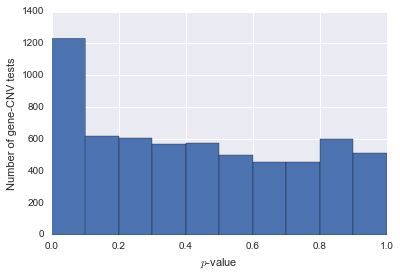

In [21]:
reg_results.pvalue.hist()
plt.ylabel('Number of gene-CNV tests')
plt.xlabel('$p$-value');

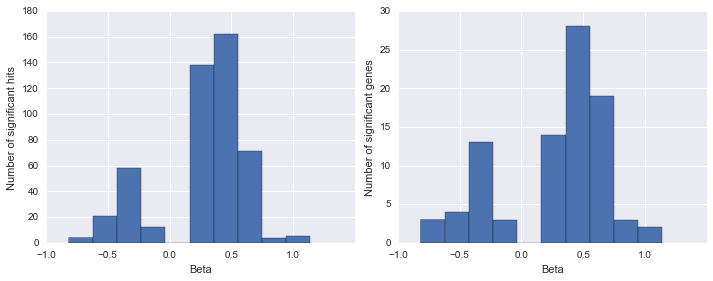

In [20]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
sig.beta.hist(ax=ax)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant hits')
ax.set_xlabel('Beta');

ax = axs[1]
sig.drop_duplicates(subset=['gene']).beta.hist(ax=axs[1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant genes')
ax.set_xlabel('Beta');
plt.tight_layout()

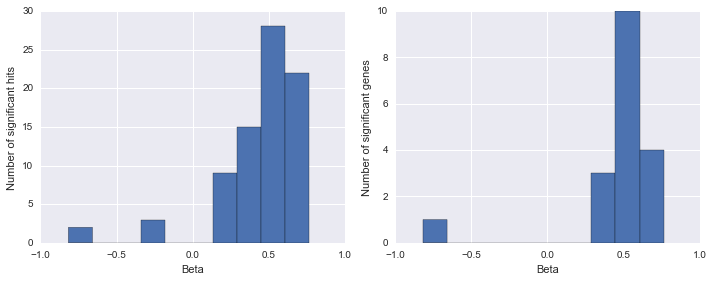

In [21]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
sig[sig.overlap_gene].beta.hist(ax=ax)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant hits')
ax.set_xlabel('Beta');

ax = axs[1]
t = sig.drop_duplicates(subset=['gene'])
t[t.overlap_gene].beta.hist(ax=axs[1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_ylabel('Number of significant genes')
ax.set_xlabel('Beta');
plt.tight_layout()

In [22]:
sig.shape

(475, 53)

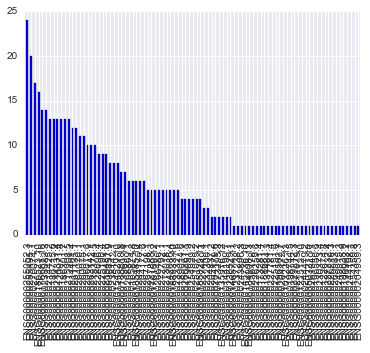

In [23]:
sig.gene.value_counts().plot(kind='bar')

In [24]:
len(set(sig.gene))

89

In [25]:
len(set(sig.ix[sig.overlap_gene, 'gene']))

24

In [26]:
sig.overlap_gene.value_counts()

False    396
True      79
Name: overlap_gene, dtype: int64

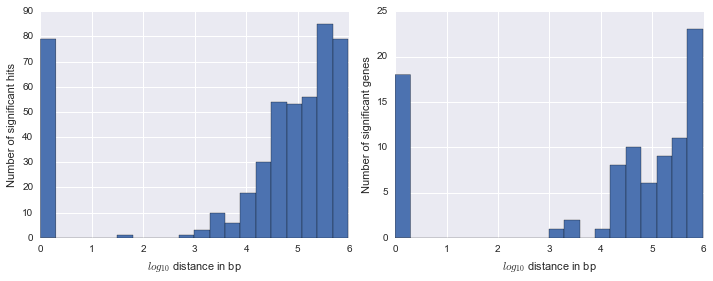

In [27]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
(np.log10(sig.dist_to_gene.abs() + 1)).hist(ax=ax, bins=20)
ax.set_ylabel('Number of significant hits')
ax.set_xlabel('$log_{10}$ distance in bp');

ax = axs[1]
(np.log10(sig.drop_duplicates(subset=['gene']).dist_to_gene.abs() + 1)).hist(ax=axs[1], bins=20)
ax.set_ylabel('Number of significant genes')
ax.set_xlabel('$log_{10}$ distance in bp');
plt.tight_layout()

In [28]:
def plot_results(gene):
    data = mcnv_data(gene)
    s = sig[sig.gene == gene]
    for c in s.cnv:
        sns.lmplot(x=c, y='exp', data=data, x_jitter=0.2)
        plt.ylabel(gene_info.ix[gene, 'gene_name'])

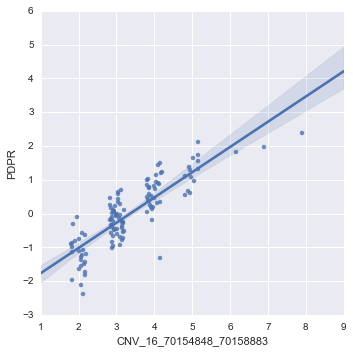

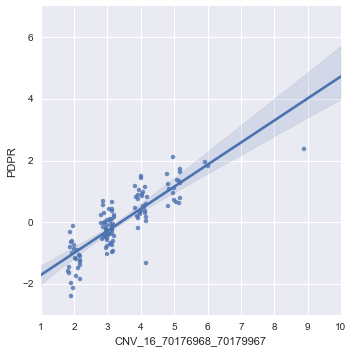

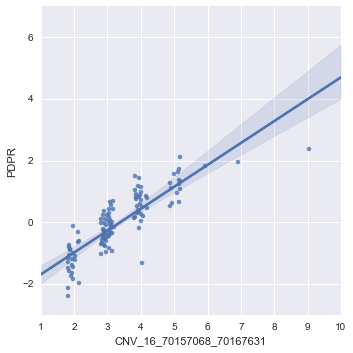

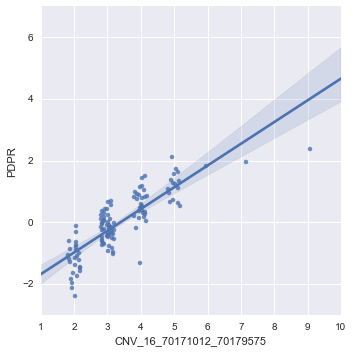

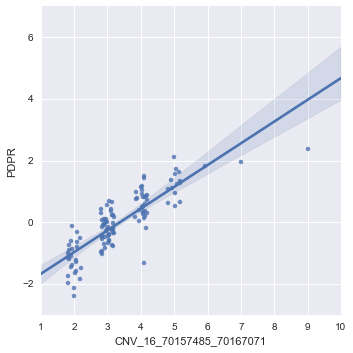

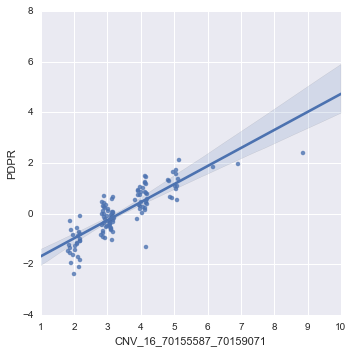

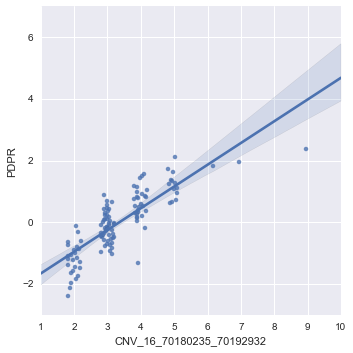

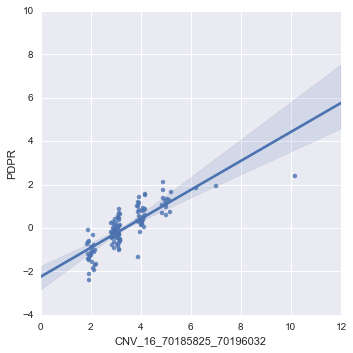

In [29]:
plot_results(sig.gene.drop_duplicates().values[0])

In [30]:
sig_cnvs = set(sig.cnv)
not_sig_cnvs = set(reg_results.cnv) - sig_cnvs
a = gs_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
a = a[a != 0]
b = gs_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
s,p = stats.mannwhitneyu(a, b)
print(p)

0.000648639720022


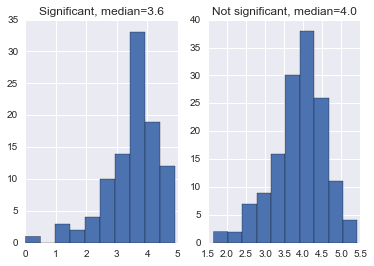

In [31]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(a.abs()).hist(ax=ax)
ax.set_title('Significant, median={:.1f}'.format(np.log10(a.abs()).median()))
ax = axs[1]
ax.set_title('Not significant, median={:.1f}'.format(np.log10(b.abs()).median()))
np.log10(b.abs()).hist(ax=ax);

In [32]:
sig_cnvs = set(sig.cnv) - set(sig.ix[sig.overlap_gene, 'cnv'])
not_sig_cnvs = set(reg_results.cnv) - sig_cnvs
a = gs_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
a = a[a != 0]
b = gs_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
s,p = stats.mannwhitneyu(a, b)
print(p)

0.224307819241


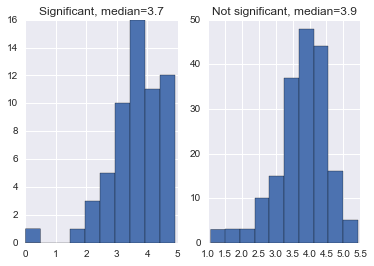

In [33]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(a.abs()).hist(ax=ax)
ax.set_title('Significant, median={:.1f}'.format(np.log10(a.abs()).median()))
ax = axs[1]
ax.set_title('Not significant, median={:.1f}'.format(np.log10(b.abs()).median()))
np.log10(b.abs()).hist(ax=ax);

Significant CNVs are closer to the TSS than not significant CNVs, although
this is not true if you remove the significant CNVs that overlap the gene.

In [ ]:
fn = os.path.join(outdir, 'go_results.tsv')
if not os.path.exists(fn):
    t = pd.Series(False, set(qvalues.index))
    t[set(sig.gene)] = True
    go_res = cpb.analysis.goseq_gene_enrichment(
        [x.split('.')[0] for x in t.index],
        t.values, 
        plot_fn=None, 
        length_correct=False)
    go_res.to_csv(fn, sep='\t')
else:
    go_res = pd.read_table(fn, index_col=0)

In [35]:
go_res.head()

,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_pvalue_bh,under_represented_pvalue_bh
category,,,,,,,,
GO:0005765,0.001959,0.999819,4,227,lysosomal membrane,CC,1,1
GO:0002408,0.002382,1.000000,1,1,myeloid dendritic cell chemotaxis,BP,1,1
GO:0034506,0.002382,1.000000,1,1,"chromosome, centromeric core domain",CC,1,1
GO:0005774,0.003476,0.999622,4,266,vacuolar membrane,CC,1,1
GO:0036324,0.004758,0.999995,1,2,vascular endothelial growth factor receptor-2 ...,BP,1,1


## Number of QTLs per mCNVs

Some mCNVs seem to have several QTLs. In most cases this seems to be because the mCNV
overlaps several genes. Sometimes multiple adjacent mCNVs will all be associated with
the same genes meaning these mCNVs should probably be merged into one large CNV.

In [ ]:
sig.sort_values(by='overlap_gene', ascending=False).drop_duplicates(subset=['gene']).overlap_gene.value_counts()

In [57]:
vc = sig.cnv.value_counts()
vc.head(15)

CNV_17_44282354_44285887    11
CNV_17_44570083_44573033    11
CNV_17_44323464_44328032    11
CNV_17_44342314_44353317    11
CNV_17_44364249_44367851    11
CNV_17_44574862_44580424    11
CNV_17_44338657_44341184    11
CNV_17_44362383_44364648    11
CNV_17_44358539_44363195    11
CNV_17_44316953_44319271    10
CNV_17_44566797_44569598    10
CNV_17_44336433_44339356    10
CNV_1_16917773_16921752      7
CNV_1_16925070_16942157      7
CNV_17_43650217_43655844     7
Name: cnv, dtype: int64

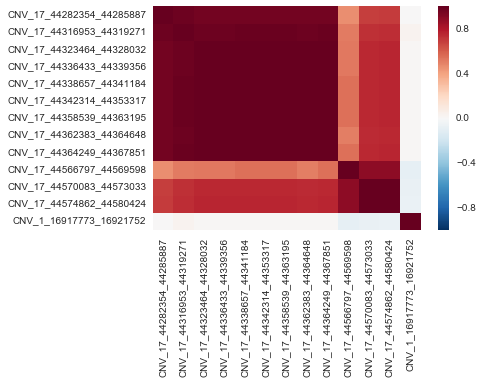

In [58]:
c = mcnvs_f.ix[sorted(vc.head(13).index)].T.corr(method='spearman')
sns.heatmap(c)

In [126]:
mcnvs_f.head().T.head().T

,34c79720-7710-4f86-b1fc-ef6565ab8459,985362a3-e536-4368-8996-2bc2db0d8fd5,4d04f714-2d68-4663-8c69-ed16606670b0,6354fc10-d70a-4453-b414-0d023f8de3b5,00ac22e8-826e-49df-8216-04571b00ac21
CNV_19_56275859_56279195,2,2,2,2,6
CNV_15_20432246_20443434,5,5,6,3,5
CNV_5_140553963_140559102,2,6,4,2,6
CNV_1_142635744_142638243,5,5,4,6,6
CNV_1_143414112_143417467,3,3,6,3,4


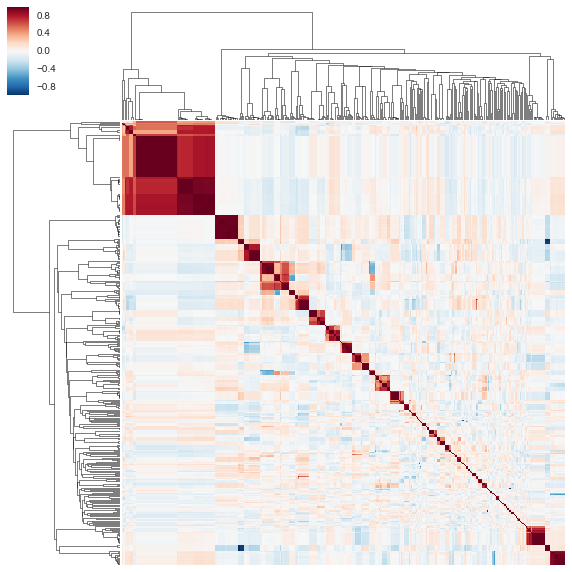

In [113]:
mcnvs_f_corr = mcnvs_f.T.corr(method='spearman')
sns.clustermap(mcnvs_f_corr, xticklabels=[], yticklabels=[]);

In [114]:
g = mcnvs_f_corr > 0.9
edges = []
for i in g.columns:
    se = g[i]
    se = se[se]
    for j in se.index:
        edges.append((i, j))
g = nx.Graph(edges)

In [111]:
cc = nx.connected_components(g)

In [118]:
cc.next()

{'CNV_1_143393455_143398395',
 'CNV_1_143414112_143417467',
 'CNV_1_143464987_143470971',
 'CNV_1_143469649_143472926',
 'CNV_21_9653659_9660562',
 'CNV_21_9660351_9664480',
 'CNV_21_9661385_9664900',
 'CNV_21_9662014_9668649',
 'CNV_21_9664581_9670889'}

In [119]:
s = {'CNV_1_143393455_143398395',
 'CNV_1_143414112_143417467',
 'CNV_1_143464987_143470971',
 'CNV_1_143469649_143472926',
 'CNV_21_9653659_9660562',
 'CNV_21_9660351_9664480',
 'CNV_21_9661385_9664900',
 'CNV_21_9662014_9668649',
 'CNV_21_9664581_9670889'}

In [124]:
mcnvs_f.ix[sorted(list(s))]

,34c79720-7710-4f86-b1fc-ef6565ab8459,985362a3-e536-4368-8996-2bc2db0d8fd5,4d04f714-2d68-4663-8c69-ed16606670b0,6354fc10-d70a-4453-b414-0d023f8de3b5,00ac22e8-826e-49df-8216-04571b00ac21,3ff1ec68-6cb9-4f9f-b2c8-5f318be79163,977ddaa3-25a9-44e8-a129-de5ee8c6bfc8,f8433b1c-dcf4-4eb2-b170-b1a218a22cd2,c9867c9b-fc41-4cfd-9020-3e6d6a46dc7b,eac917bc-c043-4cfc-b8d4-a49c373e0943,...,41b56a79-65a4-44d0-8f3e-86c7d6621fcb,9127d78b-54a1-4be2-a6b9-40097c8cbc5a,499531da-aae2-47f4-9a07-fac1baf6324c,c2a8ad0d-aaa0-4c29-a9b2-6e6617995a7d,35743bc4-9352-4bc9-8c3a-43a4cc2cef27,916c0056-cef2-488f-ae44-cb9b1398669e,61d77efd-eec4-421b-a717-4486512668da,c7a966f7-e22e-4807-afff-2bae9ca5fc72,ff2a8240-307b-43ff-9d88-cf569d566780,4f63a2f0-b270-48f8-8603-38d0de2bec74
CNV_1_143393455_143398395,3,3,5,3,4,3,6,3,6,3,...,5,3,3,2,7,4,6,4,4,4
CNV_1_143414112_143417467,3,3,6,3,4,3,6,3,6,3,...,5,3,3,2,7,4,6,4,4,4
CNV_1_143464987_143470971,3,3,6,2,4,3,6,3,6,3,...,4,3,3,2,7,3,6,4,4,4
CNV_1_143469649_143472926,3,3,6,3,4,3,6,3,6,3,...,4,3,3,2,7,3,6,4,4,4
CNV_21_9653659_9660562,5,5,8,5,6,5,8,5,8,6,...,7,5,5,4,9,6,8,6,6,6
CNV_21_9660351_9664480,4,4,7,4,5,4,7,4,7,5,...,6,4,4,3,8,5,7,5,5,5
CNV_21_9661385_9664900,5,5,8,5,6,5,9,5,8,6,...,7,5,5,4,9,6,8,6,6,6
CNV_21_9662014_9668649,5,5,8,5,6,5,9,5,8,6,...,7,5,5,4,9,6,8,6,6,6
CNV_21_9664581_9670889,5,5,8,5,6,5,8,5,8,6,...,7,5,5,4,9,6,8,6,6,6


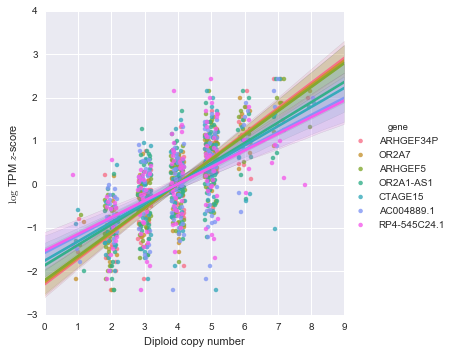

In [60]:
tt = sig[sig.cnv == 'CNV_7_143951166_143953316']

data = []
for gene in tt.gene:
    d = mcnv_data(gene)
    d['gene'] = gene_info.ix[gene, 'gene_name']
    data.append(d)
data = pd.concat(data)

data.to_csv(os.path.join(outdir, 'CNV_7_143951166_143953316_data.tsv'), sep='\t')

sns.lmplot(x='CNV_7_143951166_143953316', y='exp', data=data, hue='gene', x_jitter=0.2)
plt.ylabel('$\log$ TPM $z$-score')
plt.xlabel('Diploid copy number')
plt.savefig(os.path.join(outdir, 'CNV_7_143951166_143953316_example.pdf'))

## Intergenic

I want to find genes where no CNV overlaps the gene at all.

In [ ]:
sig_intergenic_cnvs = set(sig.cnv) - set(sig.ix[sig.overlap_gene, 'cnv'])
not_sig_cnvs = set(reg_results.cnv) - set(sig.cnv)

In [49]:
odds = []
pvalues = []
for c in roadmap_overlap.columns:
    vc = (roadmap_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        sig_overlap = 0
    else:
        sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (roadmap_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
roadmap_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=roadmap_overlap.columns)
colors = pd.DataFrame(zip(list(set([x.split('_')[-1] for x in roadmap_res.index])), 
                          cpb.analysis.tableau20[::2]), columns=['mark', 'color'])
roadmap_res['mark'] = [x.split('_')[-1] for x in roadmap_res.index]
roadmap_res['ind'] = roadmap_res.index
roadmap_res = roadmap_res.merge(colors)
roadmap_res.index = roadmap_res.ind

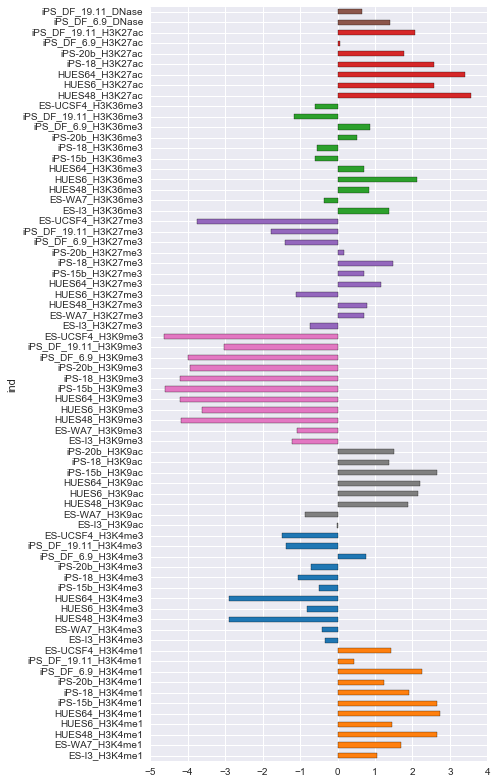

In [71]:
plt.figure(figsize=(7, 11))
(np.log2(roadmap_res.odds)).plot(kind='barh', color=roadmap_res.color)
plt.xlabel('')
plt.tight_layout()

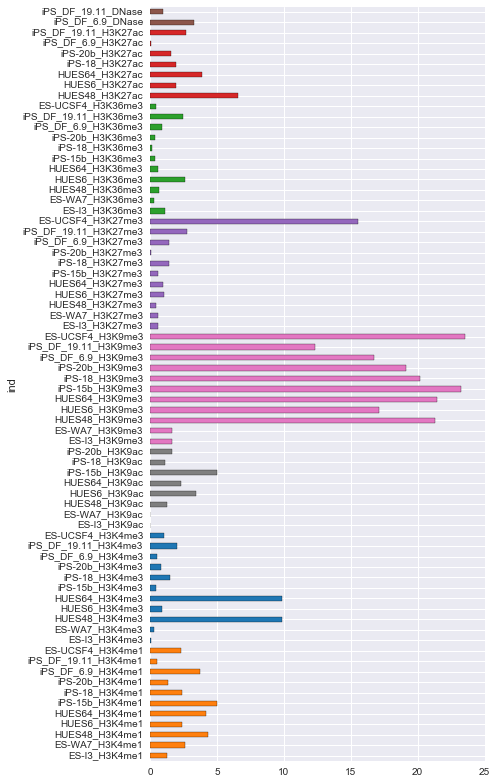

In [51]:
plt.figure(figsize=(7, 11))
(-np.log10(roadmap_res.pvalue)).plot(kind='barh', color=roadmap_res.color)
plt.tight_layout()

In [52]:
odds = []
pvalues = []
for c in encode_dnase_overlap.columns:
    vc = (encode_dnase_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (encode_dnase_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
encode_dnase_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=encode_dnase_overlap.columns)

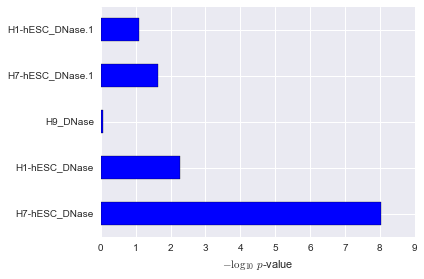

In [73]:
(-np.log10(encode_dnase_res.pvalue)).plot(kind='barh')
plt.xlabel('$-\log_{10}$ $p$-value')
plt.tight_layout()

In [54]:
odds = []
pvalues = []
for c in encode_chip_overlap.columns:
    vc = (encode_chip_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        sig_overlap = 0
    else:
        sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (encode_chip_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        not_sig_overlap = 0
    else:
        not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
encode_chip_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=encode_chip_overlap.columns)
encode_chip_res.sort_values(by='pvalue', inplace=True, ascending=False)

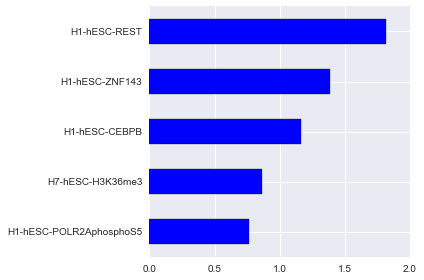

In [55]:
(-np.log10(encode_chip_res.pvalue.tail())).plot(kind='barh')
plt.tight_layout()

In [56]:
promoters = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_by_gene.bed')
df = promoters.to_dataframe()
df['gene'] = df.name.apply(lambda x: x.split('_')[0])
df['region'] = df.name.apply(lambda x: x.split('_')[2])
df.index = df.region
gb = df.groupby('gene')
gene_to_promoters = gb.groups

In [57]:
def get_hic_interactions(cnv, gene):
    # CNV location
    chrom,start,end = gs_info.ix[cnv, ['chrom', 'start', 'end']].values
    r = '{}:{}-{}'.format(chrom, start, end)
    fn = ('/projects/CARDIPS/pipeline/Hi-C/7_indv_HiC/contact_matrices/'
          'merged/normalized/iPSC/iPSC.5Kb.nor.{}.bed.gz'.format(chrom))
    t = tabix.open(fn)
    # Get lines for CNV.
    lines = []
    res = t.querys(r)
    while True:
        try:
            lines.append(res.next())
        except StopIteration:
            break
    # Get promoter regions.
    ps = [cpb.general.parse_region(x) for x in gene_to_promoters[gene]]
    # Get indices of columns for promoter regions.
    cols = []
    for x in ps:
        cols += range(int(x[1]) / 5000, int(x[2]) / 5000 + 1)
    cols = sorted(list(set(cols)))
    vals = []
    # Get values for promoter regions.
    for line in lines:
        vals.append([float(line[x + 3]) for x in cols])
    df = pd.DataFrame(vals)
    df.columns = np.array(cols) * 5000
    df.index = np.arange((start / 5000) * 5000, (end / 5000 + 1) * 5000, 5000)
    # Reflect over promoter regions and get interactions on other side.
    cnv_middle = int(start + (end - start) / 2.)
    promoter_middle = int(df.columns[0] + (df.columns[-1] - df.columns[0]) / 2.)
    null_start = int(2 * promoter_middle - cnv_middle - (end - start) / 2.)
    null_end = int(2 * promoter_middle - cnv_middle + (end - start) / 2.)
    if null_start < 0 or null_end < 0:
        return None, None
    else:
        # Get lines for CNV.
        r = '{}:{}-{}'.format(chrom, null_start, null_end)
        lines = []
        res = t.querys(r)
        while True:
            try:
                lines.append(res.next())
            except StopIteration:
                break
        vals = []
        # Get values for promoter regions.
        for line in lines:
            vals.append([float(line[x + 3]) for x in cols])
        null_df = pd.DataFrame(vals)
        null_df.columns = np.array(cols) * 5000
        null_df.index = np.arange((null_start / 5000) * 5000, (null_end / 5000 + 1) * 5000, 5000)
        return df, null_df

In [58]:
t = sig[sig.cnv.apply(lambda x: x in sig_intergenic_cnvs)]

In [59]:
real = []
null = []
dist = []
ind = []
for i in t.index:
    df, null_df = get_hic_interactions(t.ix[i, 'cnv'], t.ix[i, 'gene'])
    if df is not None:
        real.append(df.max().max())
        null.append(null_df.max().max())
        dist.append(abs(np.mean(df.columns) - np.mean(df.index)))
        ind.append(i)
real = pd.Series(real)
null = pd.Series(null)

In [60]:
hic = pd.DataFrame({'real':real.values, 'null':null.values, 'dist':dist}, index=ind)

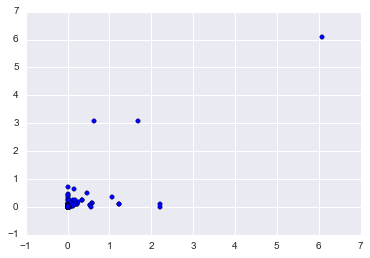

In [61]:
plt.scatter(hic.null * 10000, hic.real * 10000)

In [62]:
hic[hic.real * 10000 > 3]

,dist,null,real
2335,23333.333333,0.000169,0.000309
2337,28333.333333,0.000064,0.000309
1951,2500.000000,0.000609,0.000609


In [63]:
plot_results(t.ix[5764, 'gene'])

KeyError: 5764

In [ ]:
tdf = hic[hic.null == 0]

In [ ]:
tdf.sort_values(by='real', ascending=False, inplace=True)

In [ ]:
tdf.head()

In [ ]:
plot_results(t.ix[4537, 'gene'])